In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.auto import tqdm

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

from datetime import datetime
import time

from model.thinning_model import ThinningNet

In [2]:
def show_tensor_images(image_tensor, num_images=1, size=(1, 256, 512)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

model=ThinningNet().to(device)
model  

cuda


ThinningNet(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU(inplace=True)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU(inplace=True)
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu8): ReLU(inplace=True)
  (conv9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu9): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)

In [4]:
#training parameter
INIT_LR = 1e-2
BATCH_SIZE = 4
EPOCHS = 10

#lossFn = nn.L1Loss() 
#lossFn = BCEWithLogitsLoss()
lossFn = nn.MSELoss()


#opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
opt = torch.optim.SGD(model.parameters(), lr=INIT_LR, momentum=0.9)

In [5]:
data_dir ='./dataset/'

trainTransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

valTransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

trainDataset = ImageFolder(os.path.join(data_dir,'train'), transform = trainTransforms)
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE,shuffle=True)

valDataset = ImageFolder(os.path.join(data_dir,'val'), transform = valTransforms)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE,shuffle=True)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('Length train:',len(trainDataLoader.dataset))
print('BATCH_SIZE',BATCH_SIZE)
print('trainSteps:',trainSteps)
  
loss_train=[]
loss_val=[]

print('\nBegin trainning ...\n')
startTime = time.time()

for e in range(0,EPOCHS):
    #train model
    model.train()
    
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
   
    totalTrainLoss = 0
    totalValLoss = 0
    
    for image, _ in tqdm(trainDataLoader):
        
        im_width =  image.shape[2]
        
        real_input  = image[:, :, :im_width // 2]
        real_output = image[:, :, im_width // 2:]
            
        real_input = real_input.to(device)
        real_output = real_output.to(device)
            
        output = model(real_input)
        loss = lossFn(output, real_output)
            
        opt.zero_grad()
        loss.backward() 
        opt.step()
        
        totalTrainLoss += loss.item()
      
    avgTrainLoss = totalTrainLoss / trainSteps  
    loss_train.append(avgTrainLoss) 
       
    
    print("Train loss in epoch {} is {}".format(e+1,avgTrainLoss))
    print("========================================================")
    
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for image, _ in tqdm(valDataLoader):
            im_width =  image.shape[2]
            real_input  = image[:, :, :im_width // 2]
            real_output = image[:, :, im_width // 2:]
            
            real_input = real_input.to(device)
            real_output = real_output.to(device)
            
            # make the predictions and calculate the validation loss
            output = model(real_input)
            loss = lossFn(output, real_output)
            totalValLoss += loss.item()
      
    avgValLoss = totalValLoss / valSteps
    loss_val.append(avgValLoss)
    
endTime = time.time()

print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

now = datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S")

str =  "\n{} Loss after {} epoch: {}, min loss = {}".format(date_time,e+1,loss_train[e], min(loss_train))  
print(str)

#Lưu loss_train vào file
text_file = open("loss-stat.txt", "a")
n = text_file.write(str)
text_file.close()

Length train: 155
BATCH_SIZE 4
trainSteps: 38

Begin trainning ...

[INFO] EPOCH: 1/10



Train loss in epoch 1 is 0.2636882834332554



[INFO] EPOCH: 2/10



Train loss in epoch 2 is 0.03399005716078376



[INFO] EPOCH: 3/10



Train loss in epoch 3 is 0.034101912457691994



[INFO] EPOCH: 4/10



Train loss in epoch 4 is 0.03313525751429169



[INFO] EPOCH: 5/10



Train loss in epoch 5 is 0.03255770725541209



[INFO] EPOCH: 6/10



Train loss in epoch 6 is 0.03255843829461619



[INFO] EPOCH: 7/10



Train loss in epoch 7 is 0.032433930980531794



[INFO] EPOCH: 8/10



Train loss in epoch 8 is 0.032421029123820756



[INFO] EPOCH: 9/10



Train loss in epoch 9 is 0.032423451150718485



[INFO] EPOCH: 10/10



Train loss in epoch 10 is 0.032394620884013806



Total time taken to train the model: 491.12s

20211122_170004 Loss after 10 epoch: 0.032394620884013806, min loss = 0.032394620884013806


Train loss after 10 epoch: 0.032394620884013806, min loss = 0.032394620884013806
Val loss after 10 epoch: 0.02409872350593408



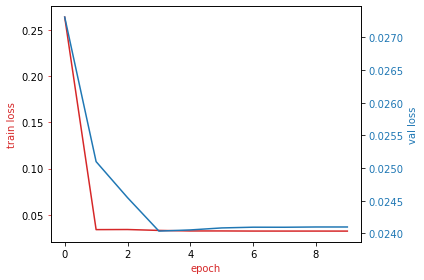

In [9]:
print("Train loss after {} epoch: {}, min loss = {}".format(e+1,loss_train[e],min(loss_train)))
print("Val loss after {} epoch: {}\n".format(e+1,loss_val[e]))


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_train,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('train loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('val loss', color=color)  
ax2.plot(loss_val, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [10]:
torch.save(model, "./output/{}_thinner_{:.4f}.pth".format(date_time,loss_train[e]))

Test loss:  0.07072876393795013

Output real:


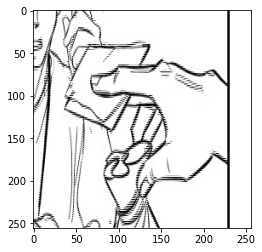

===
Output model predict:


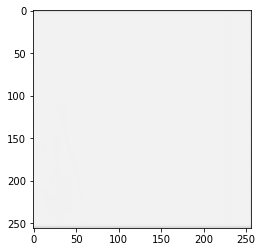

In [11]:
testTransforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

testDataset = ImageFolder(os.path.join(data_dir,'test'), transform = trainTransforms)
testDataLoader = DataLoader(testDataset, batch_size=1,shuffle=True)

torch.no_grad()
load_path ='./output/20211122_170004_thinner_0.0324.pth'

model = torch.load(load_path)
model.eval()

for image, _ in tqdm(testDataLoader):        
    im_width =  image.shape[2]        
    real_input  = image[:, :, :im_width // 2]
    real_output = image[:, :, im_width // 2:]
            
    real_input = real_input.to(device)
    real_output = real_output.to(device)
            
    output = model(real_input)
    
    loss = lossFn(output, real_output)
    print('Test loss: ',loss.item())
    
    print('\nOutput real:')
    show_tensor_images(real_output,1,(1, 256, 256))
    print('===')
    print('Output model predict:')
    show_tensor_images(output,1,(1, 256, 256))